# Parkinsons-Classification-Analysis

# Imports

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, fbeta_score, accuracy_score, make_scorer

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

# Functions

In [67]:
def check_nulls_dupes(df):
  print(f"The Amount of Null Values: {df.isna().sum()}")
  print(f"The Amount of Null Values: {df.duplicated().sum()}")

def check_class_balance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 6))
  plt.title("Target Class Breakdown")
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.show()
  
  plt.figure(figsize=(10, 6))
  plt.title("Target Class Breakdown")
  sns.countplot(x=target)
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def plot_model_performance(df, y, axis):
  
  fig, ax = plt.subplots(figsize=(20, 15))
  df.plot.bar(x="Model", y=y, ax=ax)
  ax.set_xlabel("Model Performance")
  ax.set_ylabel(axis)
  ax.set_title("Models")
  ax.grid(True)
  plt.legend(y)
  plt.xticks(rotation=45)
  plt.show()
  

def grab_selected_models(model_names):
  models = {
    "LR": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVC": SVC(),
    "KNN":KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
    "XGB": XGBClassifier(),
    "Dummy": DummyClassifier(strategy="constant", constant=1)
  }
  
  return [models[model] for model in model_names]

def grab_selected_sampling_models(model_names):
  models = {
    "SMOTE":SMOTE(),
    "BL-SMOTE":BorderlineSMOTE(),
    "ADASYN": ADASYN(),
    "KNN-SMOTE": SMOTE(k_neighbors=5),
    "SMOTE-T": SMOTETomek(),
    "SMOTENN": SMOTEENN(),
    "RANDOM":RandomOverSampler()
  }
  
  return [models[model] for model in model_names]

def create_plot_graph(metrics, axis, sort_col):
  df = pd.DataFrame(metrics).sort_values(by=sort_col, ascending=False)
  y = [col for col in df.columns if col !="Model"]
  plot_model_performance(df, y, axis)
  print(df)

def create_sklearn_pipeline(model_name, model):
  
  steps = [
    ("Scaler", StandardScaler()),
    ("PowerTransformer", PowerTransformer()),
    (model_name, model)
  ]
  
  return sklearnPipeline(steps=steps)

def create_imb_pipeline(sample_model_name, sample_model, model_name, model):
  
  steps = [
    ("Scaler", StandardScaler()),
    ("PowerTransformer", PowerTransformer()),
    (sample_model_name, sample_model),
    (model_name, model)
  ]
  
  return imbPipeline(steps=steps)

def evaluate_model(model, X, y, scoring_metric):
  cv = RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=42)
  scores = cross_val_score(model, X, y, cv=cv, scoring=scoring_metric, n_jobs=-1)
  predictions = cross_val_predict(model, X, y, cv=10)
  
  acc = accuracy_score(y, predictions)
  f1_metric = f1_score(y, predictions, average="weighted")
  recall_metric = recall_score(y, predictions)
  precision_metric = precision_score(y, predictions)
  f2_metric = fbeta_score(y,predictions, beta=2)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(f1_metric, 3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f2_metric,3),
  ]

def test_selected_models(model_names, models, X, y, scoring_metric):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline(model_name, model)
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "F1-Score":scores[4],
      "recall-Score":scores[5],
      "precision-Score":scores[5],
      "F2-Score":scores[6]
    })
  
  create_plot_graph(metric_tracker, "metrics", "Mean")

def test_selected_sampling_models(sample_model_names, sample_models, model_names, models, 
                                  X, y, scoring_metric):
  
  metric_tracker = []
  for sample_model, sample_model_name in zip(sample_models, sample_model_names):
    for model, model_name in zip(models, model_names):
      pipeline = create_imb_pipeline(sample_model_name,sample_model, model_name, model)
      scores = evaluate_model(pipeline, X, y, scoring_metric)
      
      metric_tracker.append({
        "Model": model_name +"-" + sample_model_name,
        "Mean": scores[0],
        "Var": scores[1],
        "STD": scores[2],
        "Test-Acc":scores[3],
        "F1-Score":scores[4],
        "recall-Score":scores[5],
        "precision-Score":scores[5],
        "F2-Score":scores[6]
      })
  create_plot_graph(metric_tracker, "metrics", "Mean")

# EDA Analysis

In [4]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


# Check for Nulls and Dupes

In [6]:
check_nulls_dupes(df)

The Amount of Null Values: name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64
The Amount of Null Values: 0


# Check For Class Imbalance

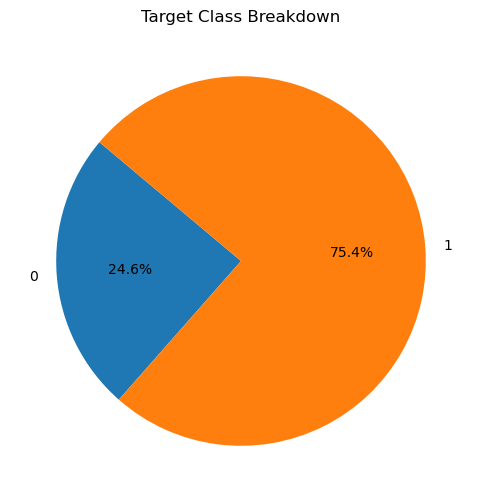

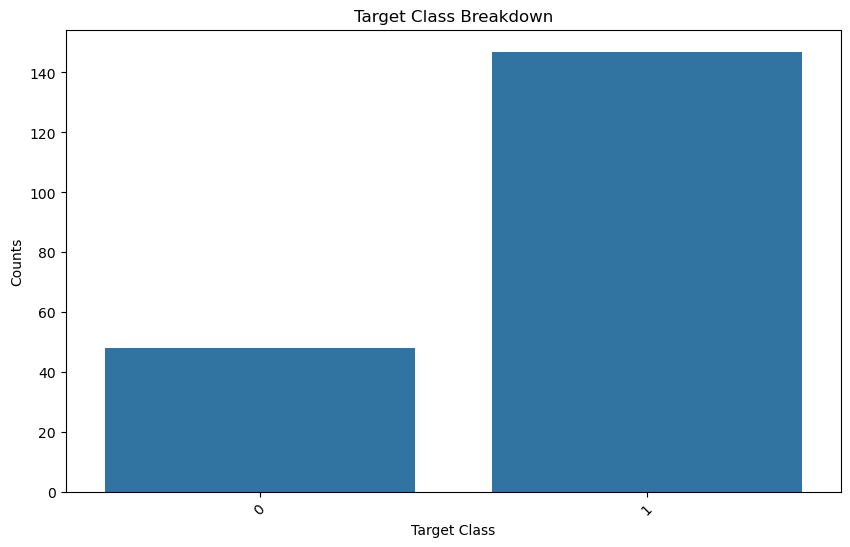

In [7]:
check_class_balance(df["status"])

# We have a severe class imbalance

In [30]:
df["name"].value_counts()

phon_R01_S01_1    1
phon_R01_S35_1    1
phon_R01_S31_3    1
phon_R01_S31_4    1
phon_R01_S31_5    1
                 ..
phon_R01_S18_2    1
phon_R01_S18_3    1
phon_R01_S18_4    1
phon_R01_S18_5    1
phon_R01_S50_6    1
Name: name, Length: 195, dtype: int64

In [31]:
df.drop("name", axis=1, inplace=True)

In [8]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [9]:
df.dtypes

name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
dtype: object

# Visuals

<AxesSubplot:>

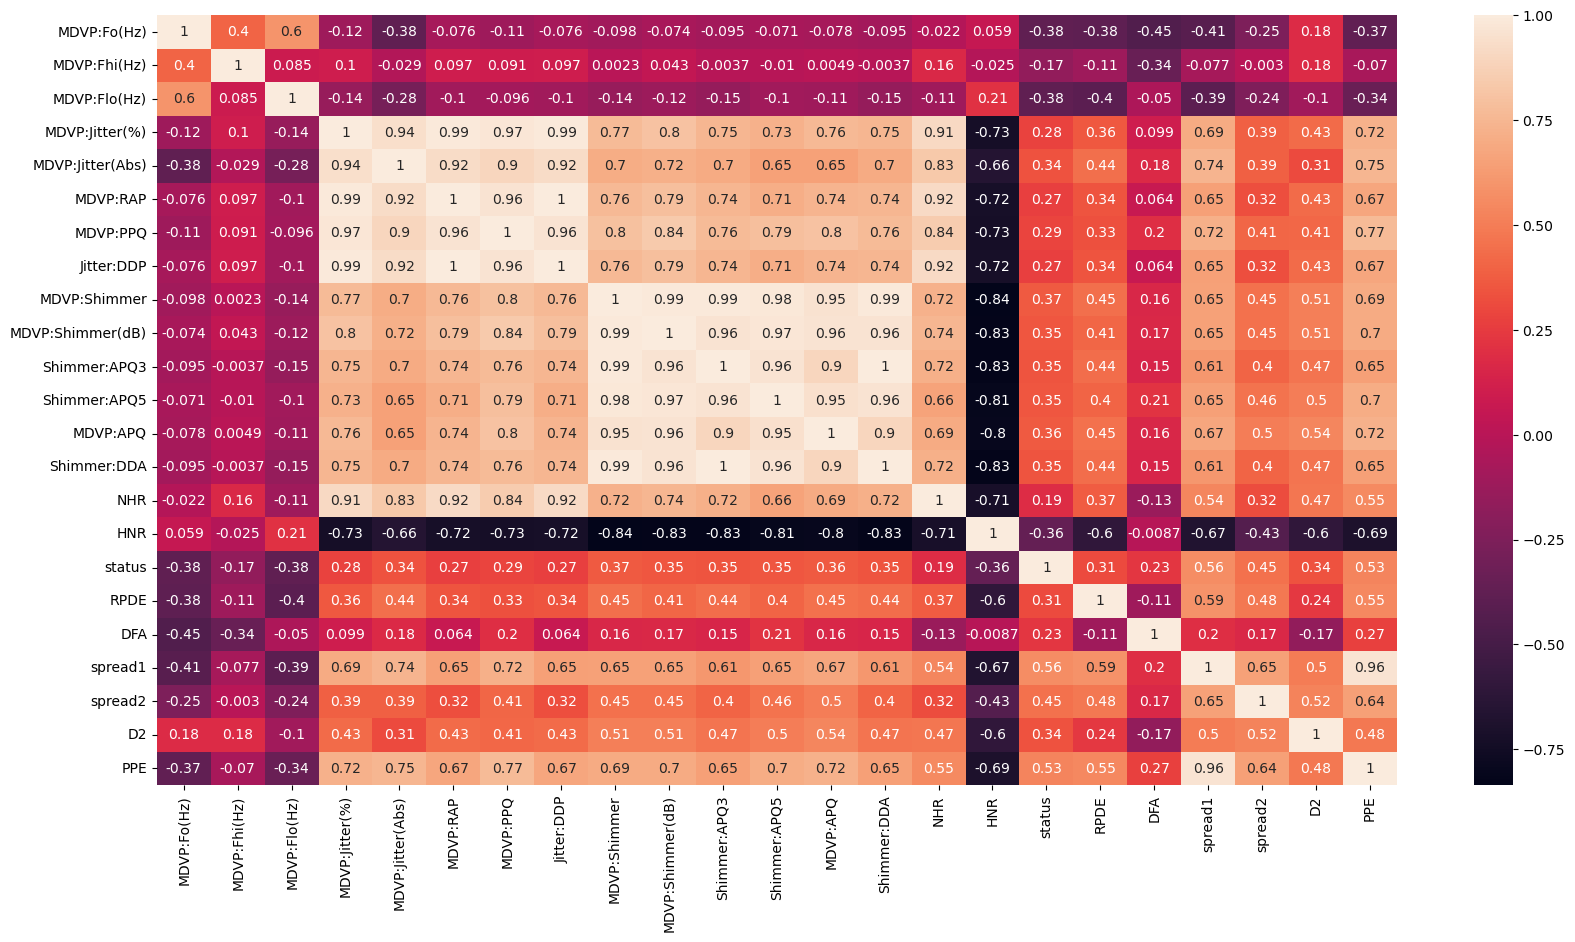

In [11]:
relations = df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(data=relations, annot=True)

# Due to the degree of columns we're bound to have correlations that may appear to be strong relationships but could be in fact hot air.

# Hist Plot Visuals

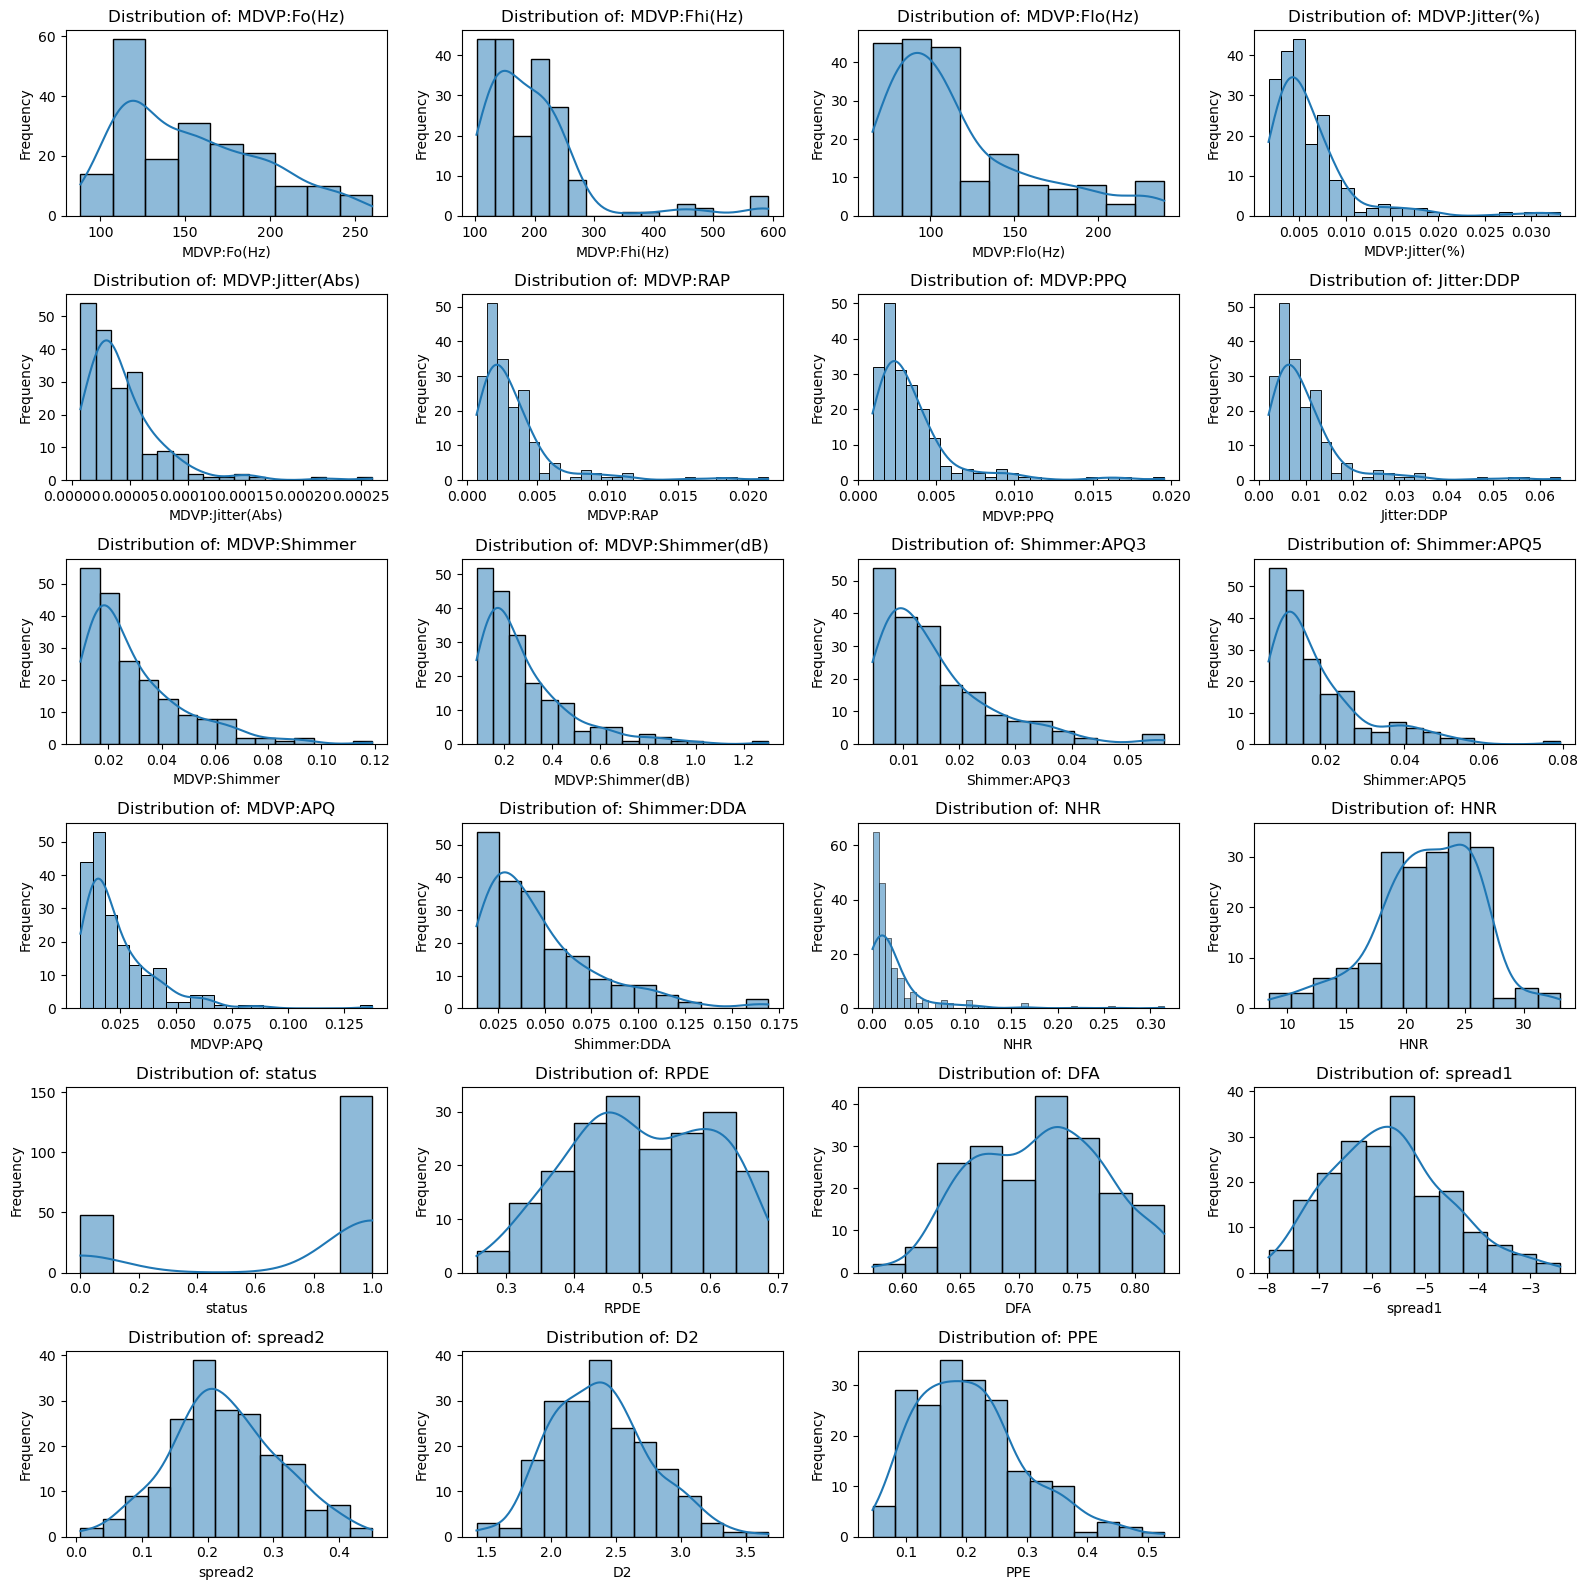

In [33]:
plt.figure(figsize=(16,16))
rows = len(df.columns)
dims = (rows+3)//4

for idx, col in enumerate(df.columns):
  plt.subplot(dims, 4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f'Distribution of: {col}')
  plt.xlabel(col)
  plt.ylabel("Frequency")
  
plt.tight_layout()
plt.show()

# Box Plot Visuals

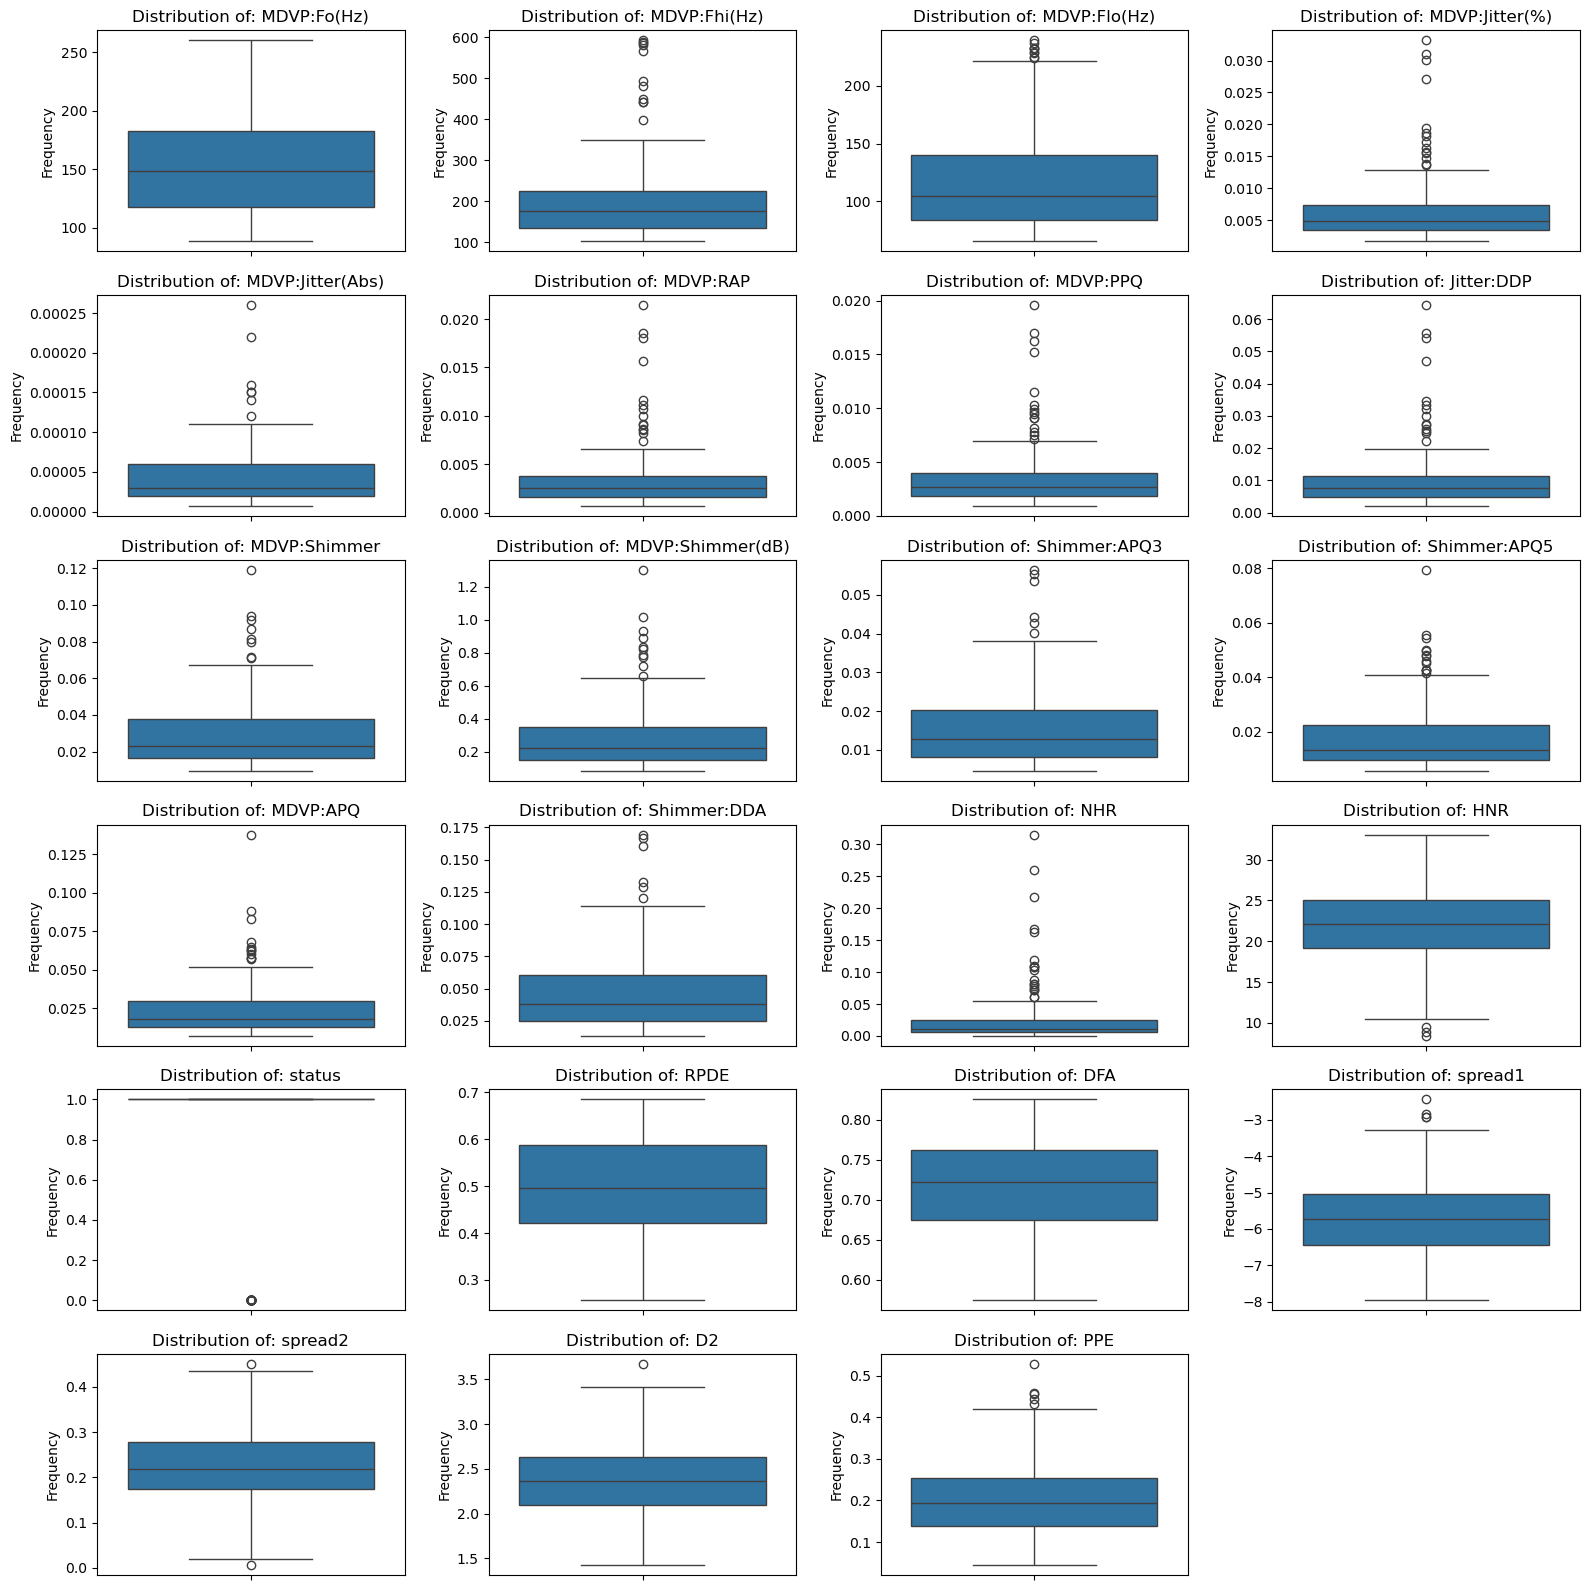

In [32]:
plt.figure(figsize=(16,16))
rows = len(df.columns)
dims = (rows+3)//4

for idx, col in enumerate(df.columns):
  plt.subplot(dims, 4, idx+1)
  sns.boxplot(df[col])
  plt.title(f'Distribution of: {col}')
  plt.ylabel("Frequency")
  
plt.tight_layout()
plt.show()

# Separate Feature Variables

In [34]:
X, y = df.drop("status", axis=1), df["status"]

# Create Metrics

In [26]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, average="weighted", greater_is_better=True)
f2_metric = make_scorer(fbeta_score, beta=2, greater_is_better=True)
precision_metric = make_scorer(precision_score, greater_is_better=True)
recall_metric = make_scorer(recall_score, greater_is_better=True)

# Model Evaluation

## How should we test out model? On what metrics will achieve our objective?

## What should our objective be?

### Given that this is something as serious as predicting parkinsons disease we may want to give equal weight to precision and recall which would mean valuing the f1 metric on the other hand we may want to negate the change of false positives. In theory, a correct diagnosis early on may lead to better treatment solutions. I am not a SME expert but a incorrect diagnosis could lead to the possibility of ruling out other potential diseases or complications in the patient. It is important to discuss this with a SME. For now, we will test various metrics and assess the trade offs. I am leaning towards f1, f2 and recall as my main scoring metrics.

# Baseline Model

# We're going to a test a dummy model that predicts the minority class no matter what the input is and see the results.

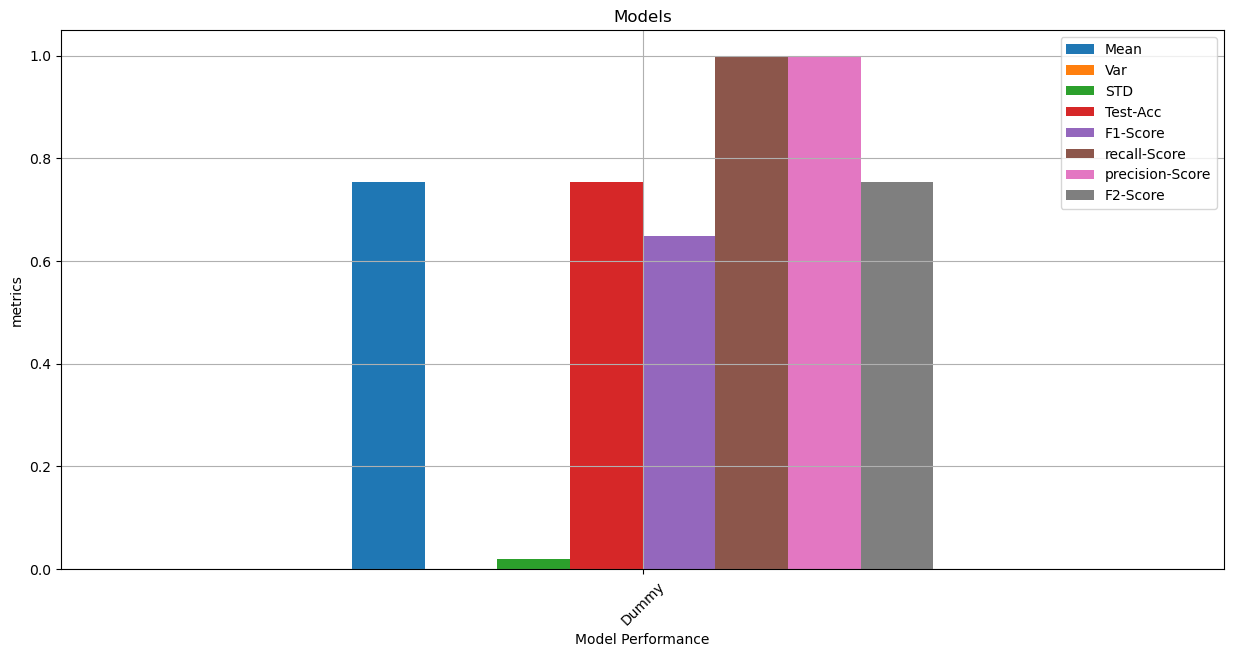

   Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  \
0  Dummy  0.754  0.0  0.019     0.754     0.648           1.0   

   precision-Score  F2-Score  
0              1.0     0.754  


In [43]:
model_names = ["Dummy"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, X, y, acc_metric)

# Given that our model is imbalanced for our target class, these results using accuracy are useless but its important to test and see the results.

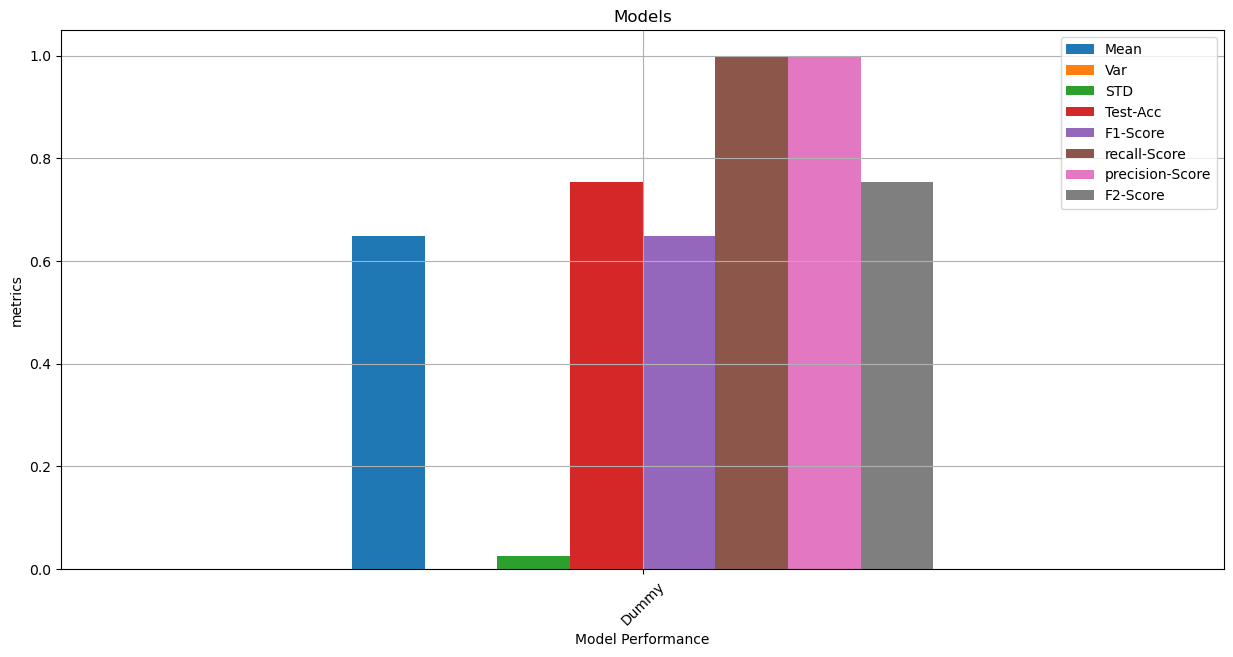

   Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0  Dummy  0.648  0.001  0.025     0.754     0.648           1.0   

   precision-Score  F2-Score  
0              1.0     0.754  


In [44]:
test_selected_models(model_names, models, X, y, f1_metric)

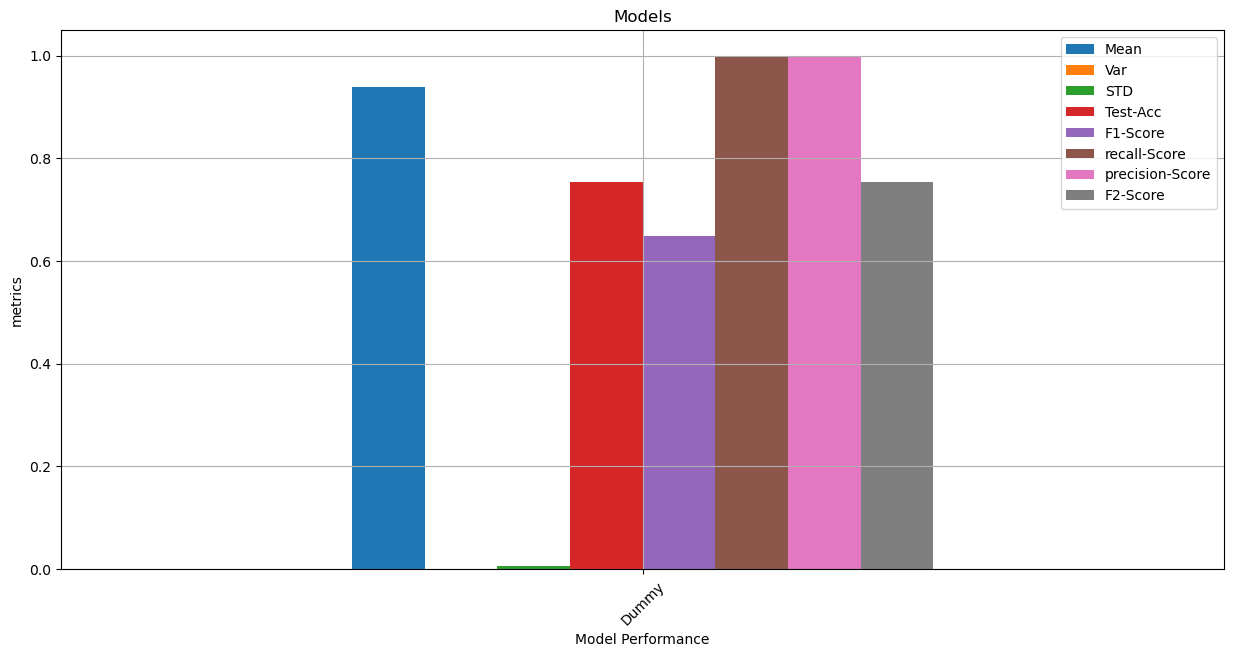

   Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  \
0  Dummy  0.939  0.0  0.006     0.754     0.648           1.0   

   precision-Score  F2-Score  
0              1.0     0.754  


In [45]:
test_selected_models(model_names, models, X, y, f2_metric)

# Notice the 30 point swing from f1-f2 in the average mean score.

# Let's test more advanced models

# Accuracy Metric

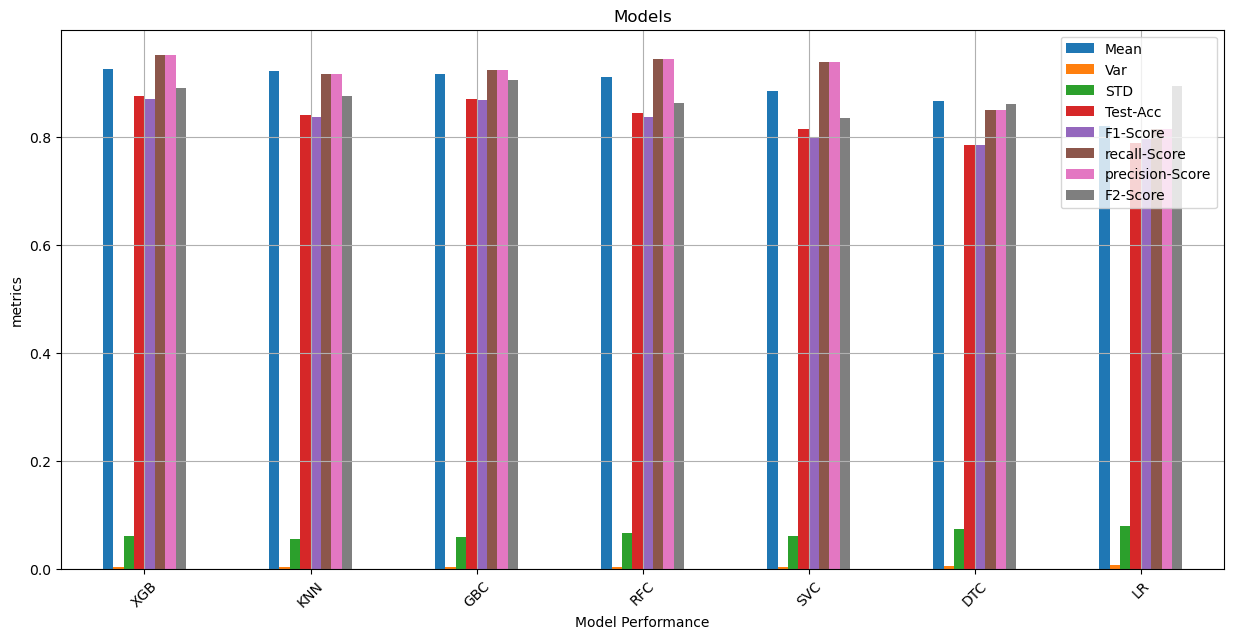

  Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
6   XGB  0.926  0.004  0.061     0.877     0.872         0.952   
2   KNN  0.923  0.003  0.056     0.841     0.837         0.918   
5   GBC  0.918  0.003  0.059     0.872     0.870         0.925   
4   RFC  0.912  0.004  0.066     0.846     0.837         0.946   
1   SVC  0.885  0.004  0.061     0.815     0.799         0.939   
3   DTC  0.868  0.005  0.073     0.785     0.786         0.850   
0    LR  0.821  0.006  0.080     0.790     0.797         0.816   

   precision-Score  F2-Score  
6            0.952     0.892  
2            0.918     0.877  
5            0.925     0.907  
4            0.946     0.863  
1            0.939     0.836  
3            0.850     0.862  
0            0.816     0.896  


In [47]:
model_names = ["LR", "SVC", "KNN", "DTC", "RFC", "GBC", "XGB"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, X, y, acc_metric)

# F1 Metric

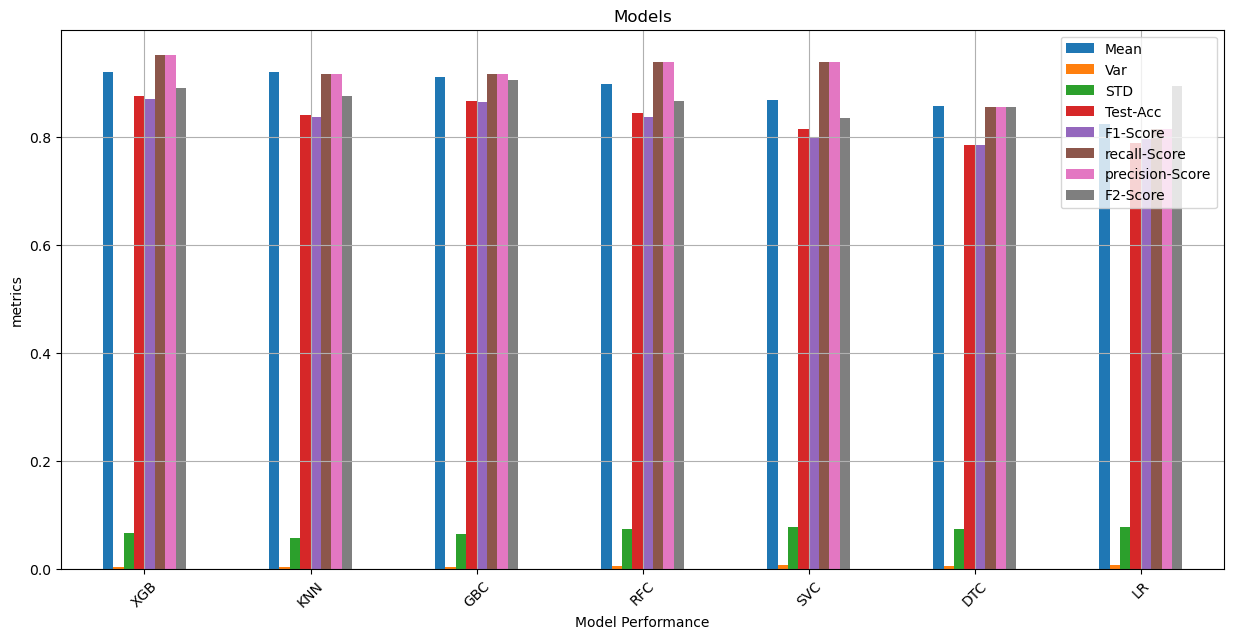

  Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
6   XGB  0.922  0.004  0.066     0.877     0.872         0.952   
2   KNN  0.921  0.003  0.057     0.841     0.837         0.918   
5   GBC  0.912  0.004  0.065     0.867     0.866         0.918   
4   RFC  0.899  0.005  0.074     0.846     0.838         0.939   
1   SVC  0.870  0.006  0.077     0.815     0.799         0.939   
3   DTC  0.859  0.005  0.074     0.785     0.785         0.857   
0    LR  0.825  0.006  0.078     0.790     0.797         0.816   

   precision-Score  F2-Score  
6            0.952     0.892  
2            0.918     0.877  
5            0.918     0.906  
4            0.939     0.868  
1            0.939     0.836  
3            0.857     0.857  
0            0.816     0.896  


In [48]:
test_selected_models(model_names, models, X, y, f1_metric)

# F2 Metric

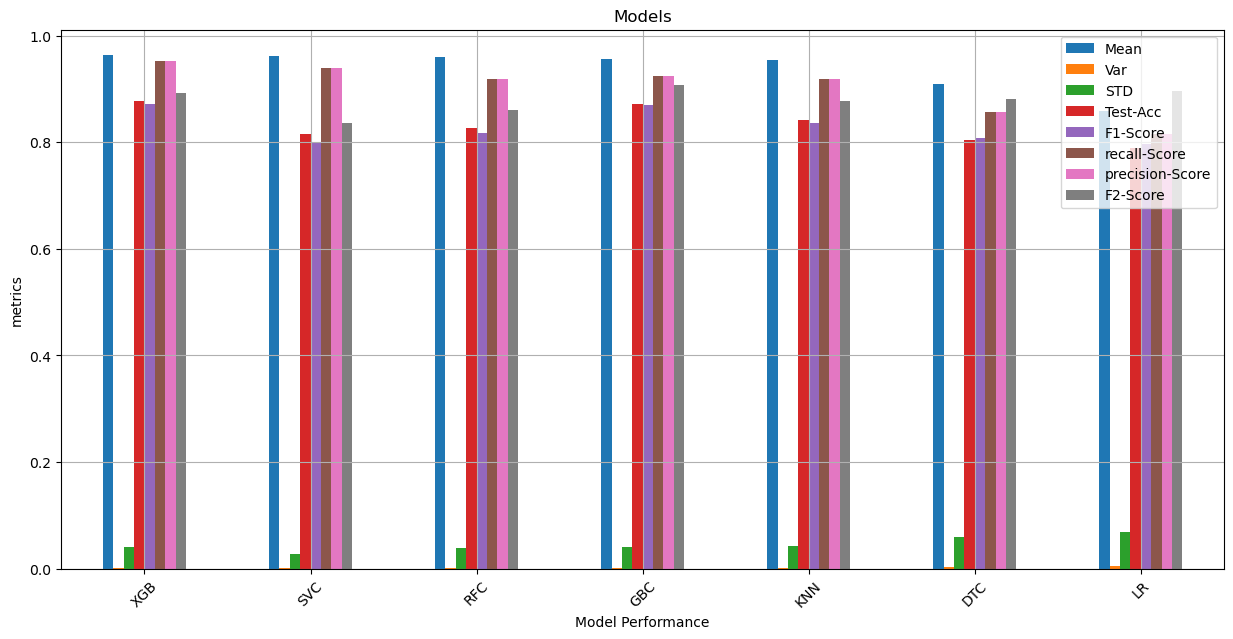

  Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
6   XGB  0.963  0.002  0.040     0.877     0.872         0.952   
1   SVC  0.961  0.001  0.028     0.815     0.799         0.939   
4   RFC  0.960  0.001  0.038     0.826     0.818         0.918   
5   GBC  0.956  0.002  0.040     0.872     0.870         0.925   
2   KNN  0.954  0.002  0.043     0.841     0.837         0.918   
3   DTC  0.909  0.004  0.060     0.805     0.808         0.857   
0    LR  0.858  0.005  0.068     0.790     0.797         0.816   

   precision-Score  F2-Score  
6            0.952     0.892  
1            0.939     0.836  
4            0.918     0.860  
5            0.925     0.907  
2            0.918     0.877  
3            0.857     0.881  
0            0.816     0.896  


In [49]:
test_selected_models(model_names, models, X, y, f2_metric)

# Due to the level of class imbalance, it is likely that our data is not able to generalize properly and contains inflated scores.

# ACC Score - Sampling Test

In [63]:
sample_model_names = ["SMOTE", "BL-SMOTE", "KNN-SMOTE", "SMOTENN", "ADASYN", "RANDOM"]
sample_models = grab_selected_sampling_models(sample_model_names)

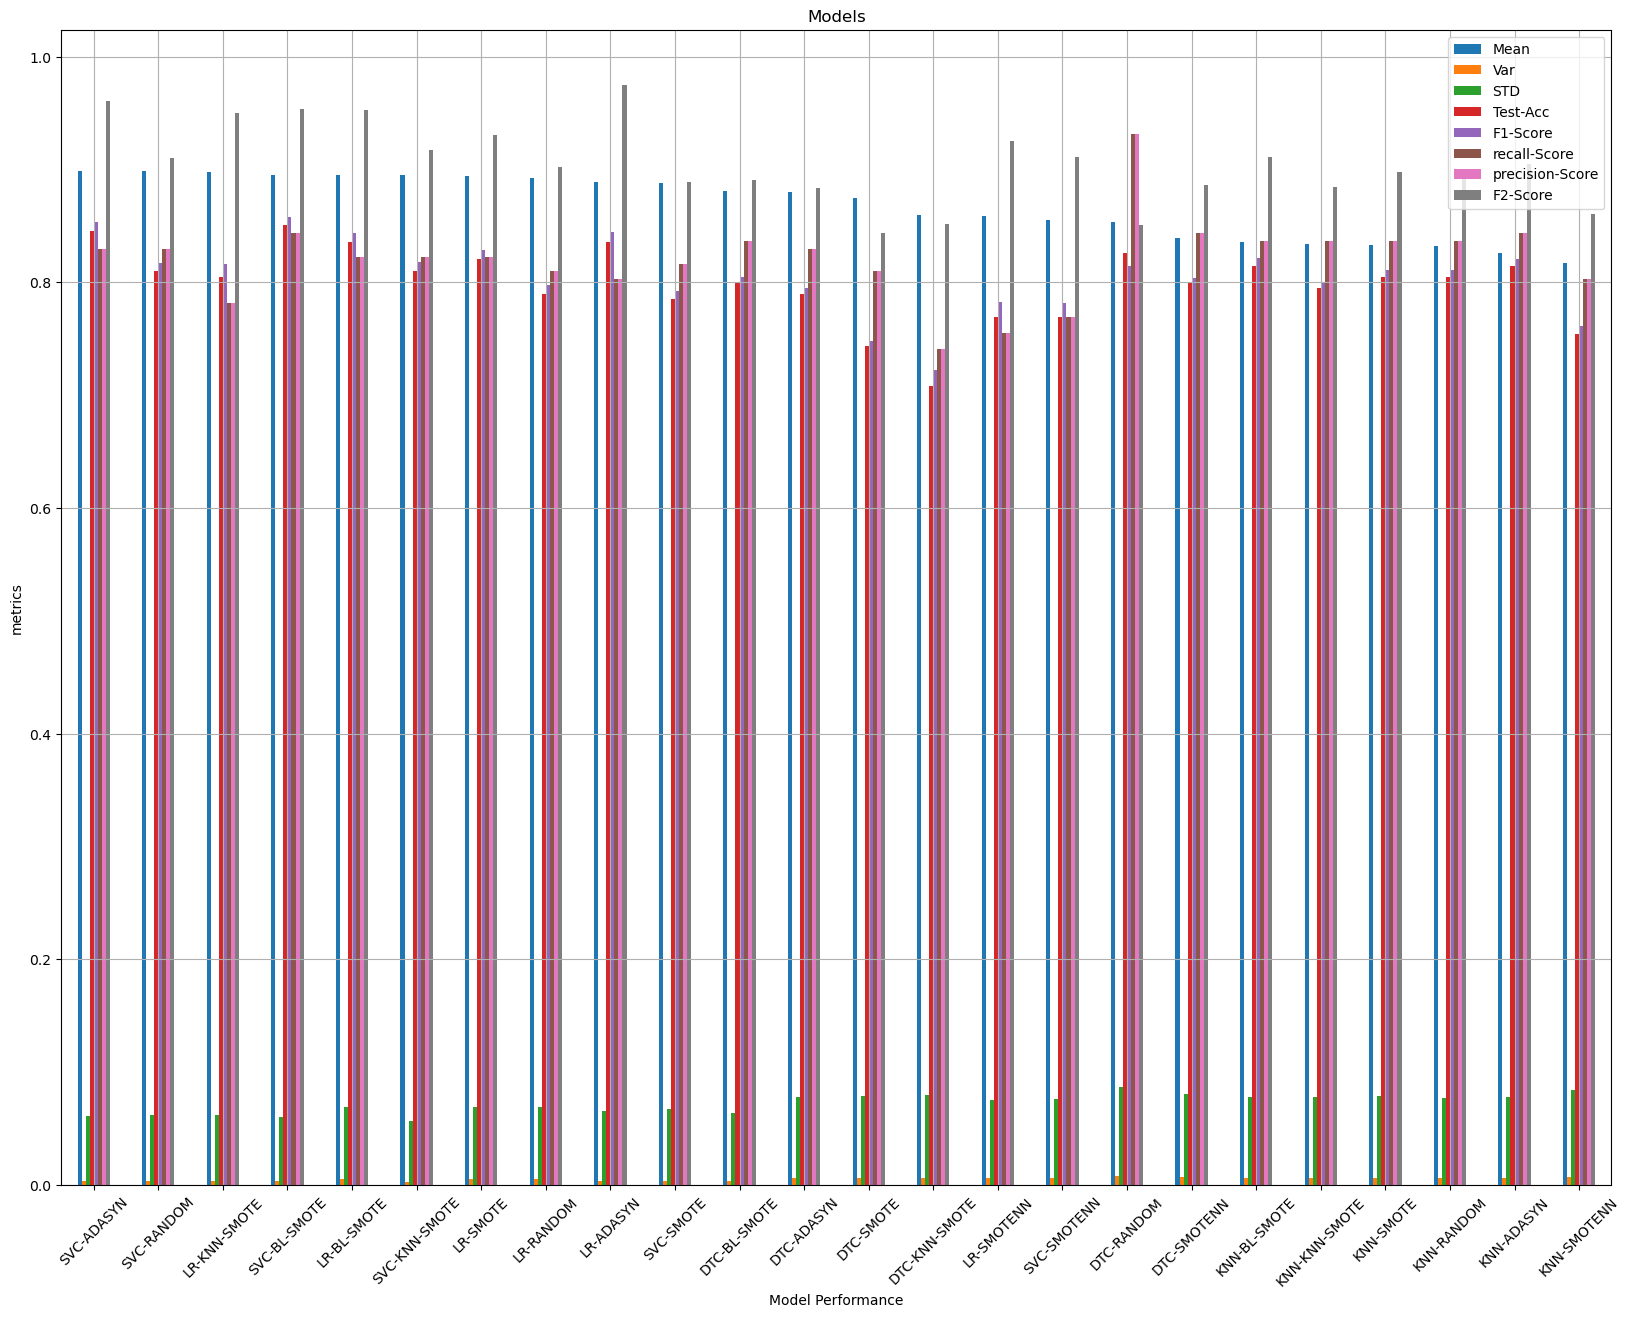

            Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
17     SVC-ADASYN  0.899  0.004  0.061     0.846     0.854         0.830   
21     SVC-RANDOM  0.899  0.004  0.062     0.810     0.817         0.830   
10   LR-KNN-SMOTE  0.898  0.004  0.062     0.805     0.816         0.782   
5    SVC-BL-SMOTE  0.895  0.004  0.060     0.851     0.858         0.844   
6     LR-BL-SMOTE  0.895  0.005  0.069     0.836     0.844         0.823   
9   SVC-KNN-SMOTE  0.895  0.003  0.057     0.810     0.818         0.823   
2        LR-SMOTE  0.894  0.005  0.069     0.821     0.829         0.823   
22      LR-RANDOM  0.893  0.005  0.069     0.790     0.798         0.810   
18      LR-ADASYN  0.889  0.004  0.066     0.836     0.845         0.803   
1       SVC-SMOTE  0.888  0.004  0.067     0.785     0.792         0.816   
7    DTC-BL-SMOTE  0.881  0.004  0.064     0.800     0.805         0.837   
19     DTC-ADASYN  0.880  0.006  0.078     0.790     0.795         0.830   
3       DTC-

In [69]:
model_names = ["KNN", "SVC", "LR", "DTC"]
grab_selected_models(model_names)
test_selected_sampling_models(sample_model_names, sample_models, model_names, models, X, y, acc_metric)

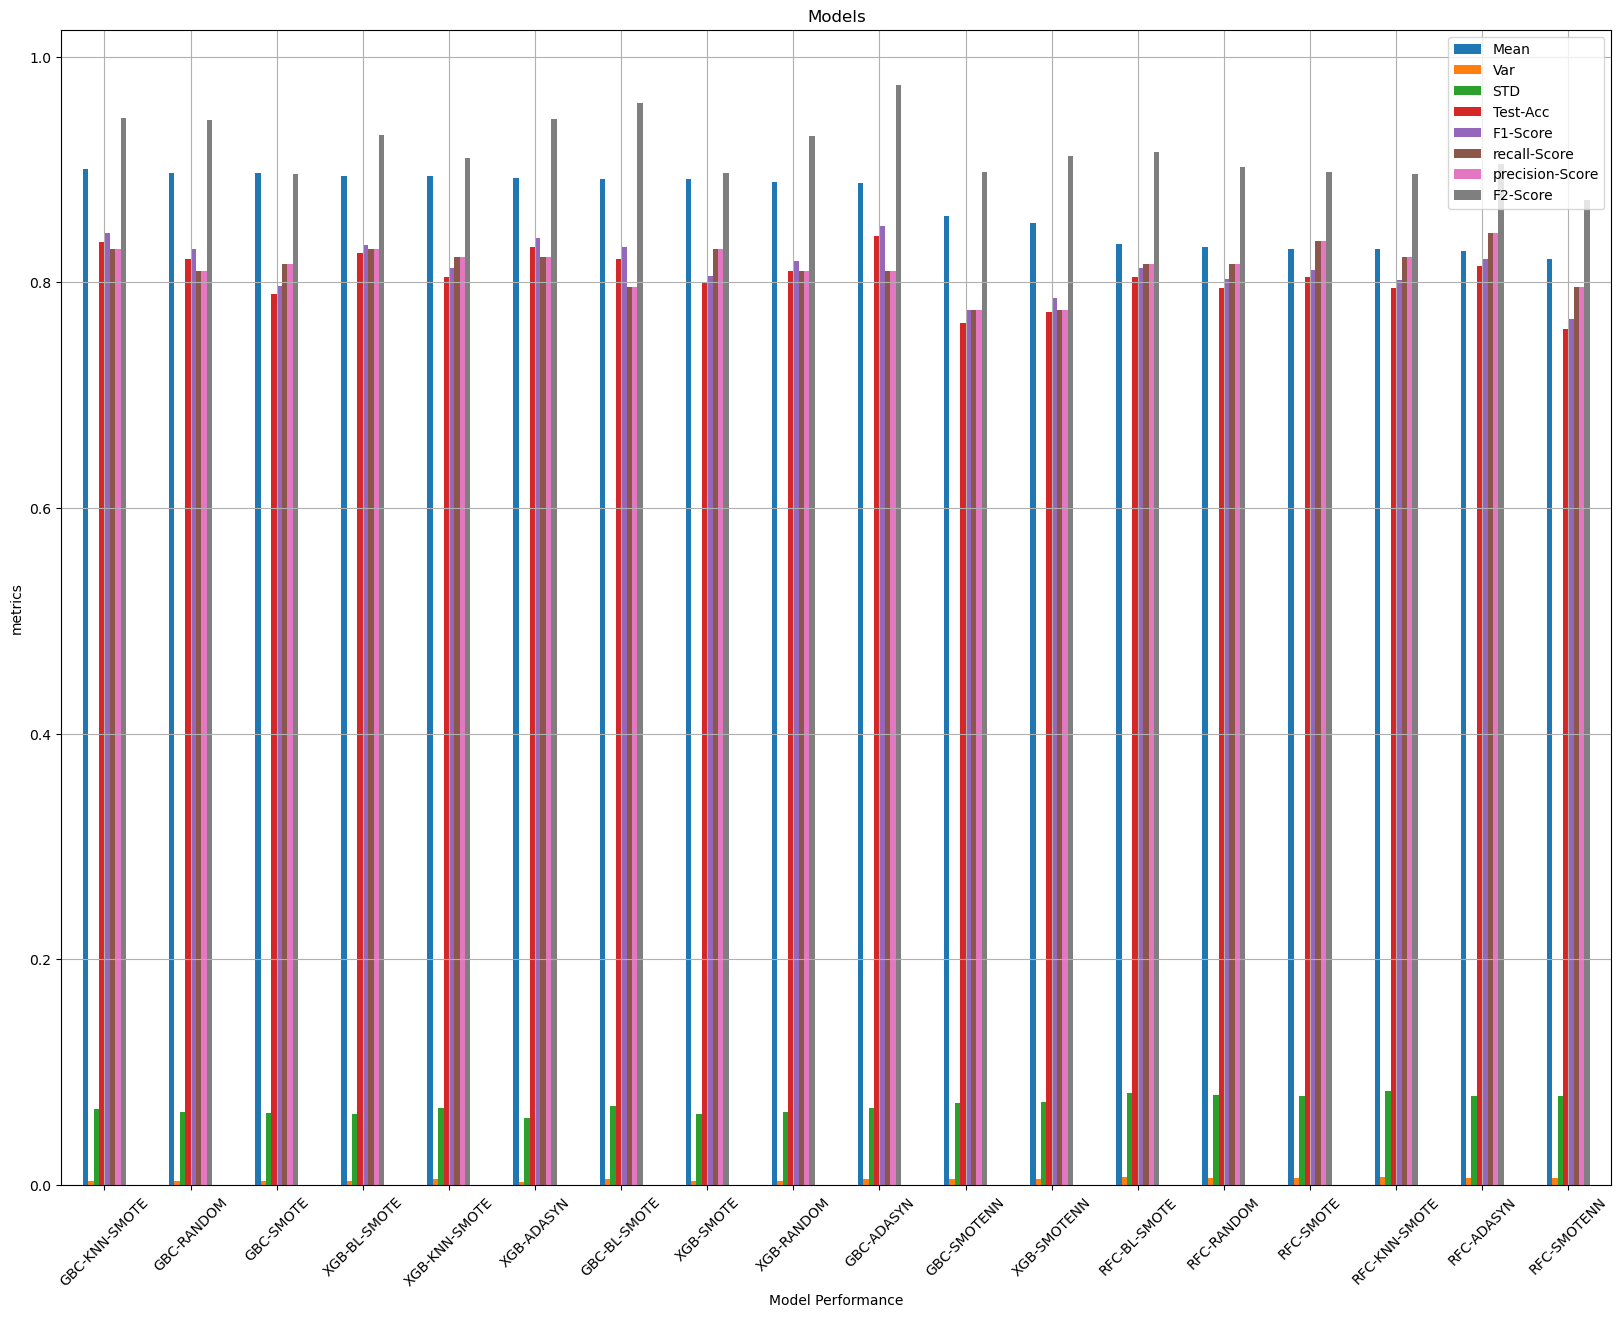

            Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
8   GBC-KNN-SMOTE  0.901  0.004  0.067     0.836     0.844         0.830   
17     GBC-RANDOM  0.897  0.004  0.065     0.821     0.830         0.810   
2       GBC-SMOTE  0.897  0.004  0.064     0.790     0.797         0.816   
4    XGB-BL-SMOTE  0.894  0.004  0.063     0.826     0.833         0.830   
7   XGB-KNN-SMOTE  0.894  0.005  0.068     0.805     0.813         0.823   
13     XGB-ADASYN  0.893  0.003  0.059     0.831     0.839         0.823   
5    GBC-BL-SMOTE  0.892  0.005  0.070     0.821     0.831         0.796   
1       XGB-SMOTE  0.892  0.004  0.063     0.800     0.806         0.830   
16     XGB-RANDOM  0.889  0.004  0.065     0.810     0.819         0.810   
14     GBC-ADASYN  0.888  0.005  0.068     0.841     0.850         0.810   
11    GBC-SMOTENN  0.859  0.005  0.073     0.764     0.776         0.776   
10    XGB-SMOTENN  0.853  0.005  0.074     0.774     0.786         0.776   
3    RFC-BL-

In [70]:
model_names = ["RFC", "XGB", "GBC"]
grab_selected_models(model_names)
test_selected_sampling_models(sample_model_names, sample_models, model_names, models, X, y, acc_metric)

# F1-Metric

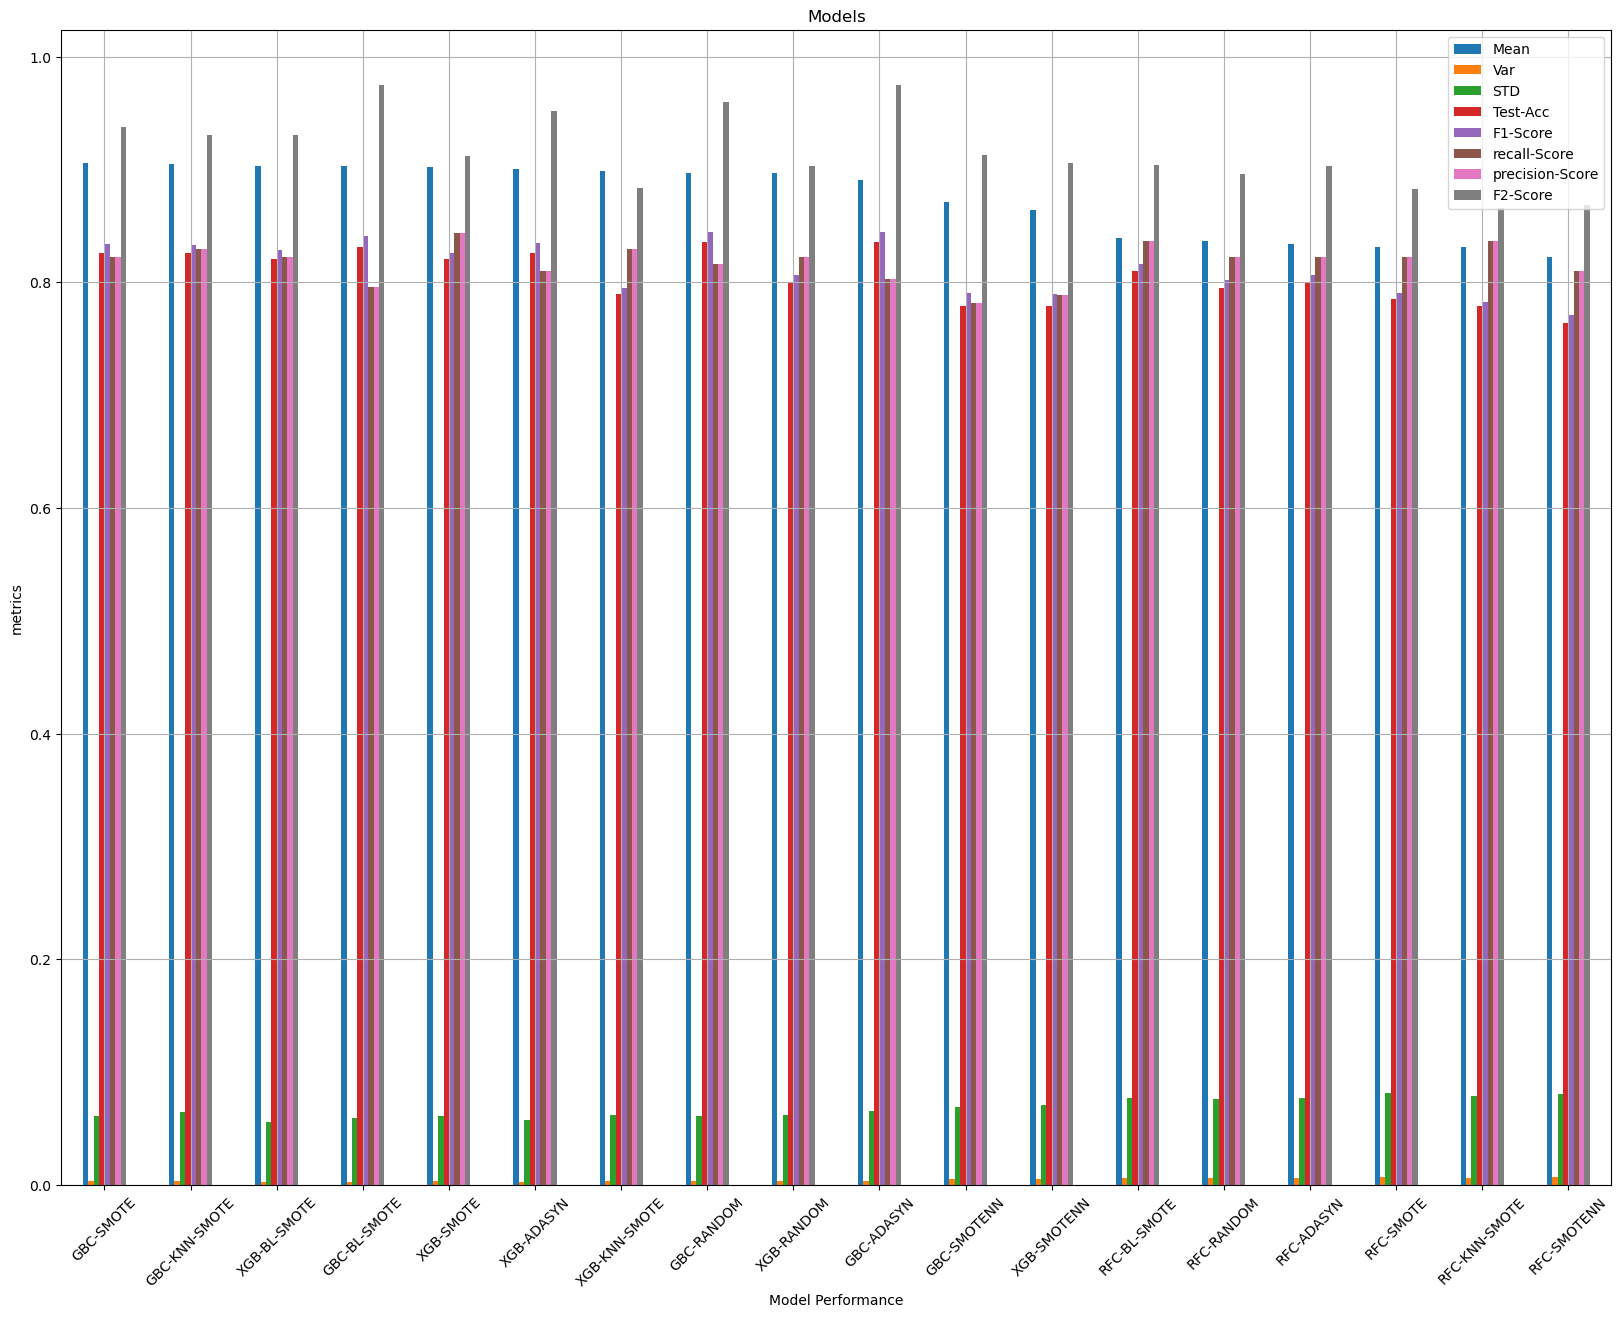

            Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
2       GBC-SMOTE  0.906  0.004  0.061     0.826     0.834         0.823   
8   GBC-KNN-SMOTE  0.905  0.004  0.065     0.826     0.833         0.830   
4    XGB-BL-SMOTE  0.903  0.003  0.056     0.821     0.829         0.823   
5    GBC-BL-SMOTE  0.903  0.003  0.059     0.831     0.841         0.796   
1       XGB-SMOTE  0.902  0.004  0.061     0.821     0.826         0.844   
13     XGB-ADASYN  0.901  0.003  0.058     0.826     0.835         0.810   
7   XGB-KNN-SMOTE  0.899  0.004  0.062     0.790     0.795         0.830   
17     GBC-RANDOM  0.897  0.004  0.061     0.836     0.845         0.816   
16     XGB-RANDOM  0.897  0.004  0.062     0.800     0.807         0.823   
14     GBC-ADASYN  0.891  0.004  0.066     0.836     0.845         0.803   
11    GBC-SMOTENN  0.871  0.005  0.069     0.779     0.791         0.782   
10    XGB-SMOTENN  0.864  0.005  0.071     0.779     0.790         0.789   
3    RFC-BL-

In [71]:
model_names = ["RFC", "XGB", "GBC"]
grab_selected_models(model_names)
test_selected_sampling_models(sample_model_names, sample_models, model_names, models, X, y, f1_metric)

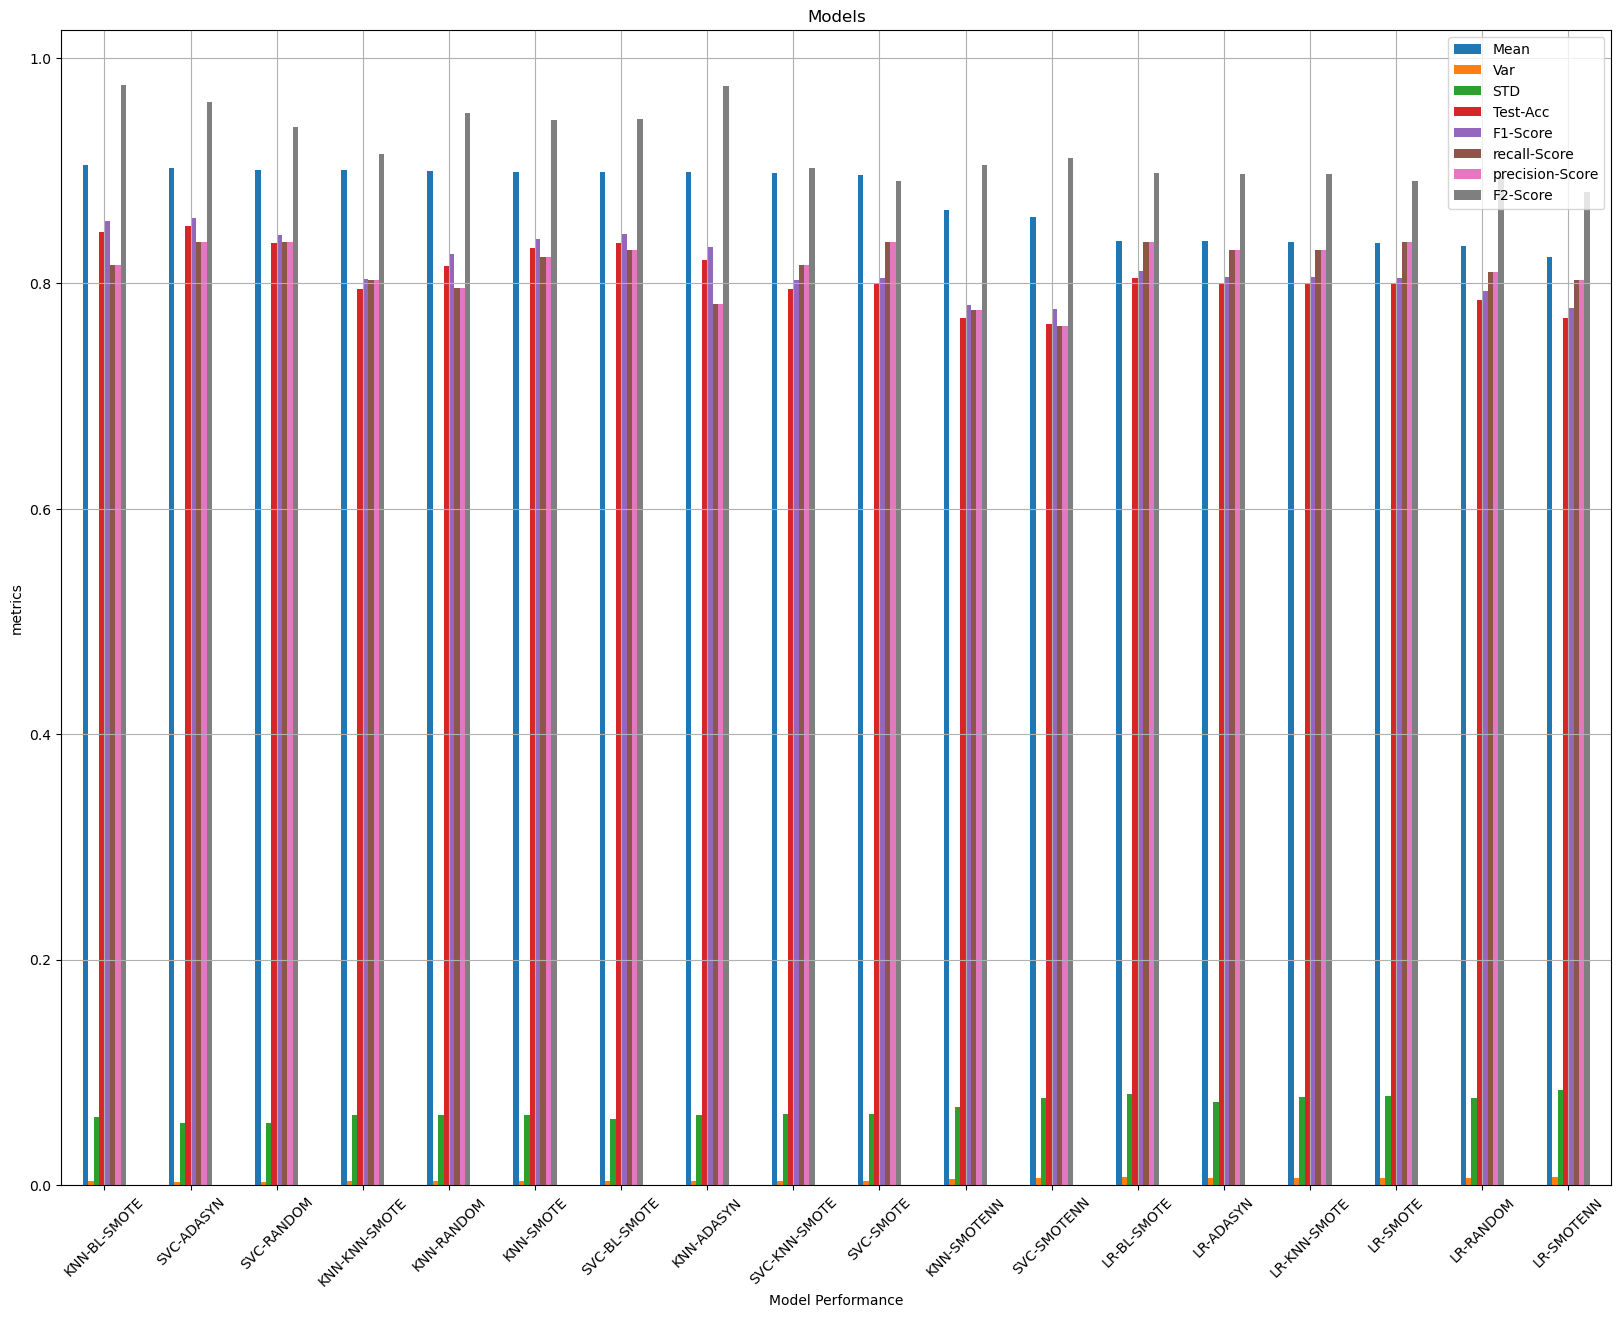

            Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
5    KNN-BL-SMOTE  0.905  0.004  0.060     0.846     0.855         0.816   
13     SVC-ADASYN  0.902  0.003  0.055     0.851     0.858         0.837   
16     SVC-RANDOM  0.901  0.003  0.055     0.836     0.843         0.837   
8   KNN-KNN-SMOTE  0.901  0.004  0.062     0.795     0.804         0.803   
17     KNN-RANDOM  0.900  0.004  0.062     0.815     0.826         0.796   
2       KNN-SMOTE  0.899  0.004  0.062     0.831     0.839         0.823   
4    SVC-BL-SMOTE  0.899  0.004  0.059     0.836     0.844         0.830   
14     KNN-ADASYN  0.899  0.004  0.062     0.821     0.832         0.782   
7   SVC-KNN-SMOTE  0.898  0.004  0.063     0.795     0.803         0.816   
1       SVC-SMOTE  0.896  0.004  0.063     0.800     0.805         0.837   
11    KNN-SMOTENN  0.865  0.005  0.069     0.769     0.781         0.776   
10    SVC-SMOTENN  0.859  0.006  0.077     0.764     0.777         0.762   
3     LR-BL-

In [72]:
model_names = ["LR", "SVC", "KNN"]
grab_selected_models(model_names)
test_selected_sampling_models(sample_model_names, sample_models, model_names, models, X, y, f1_metric)

# F2 Metric

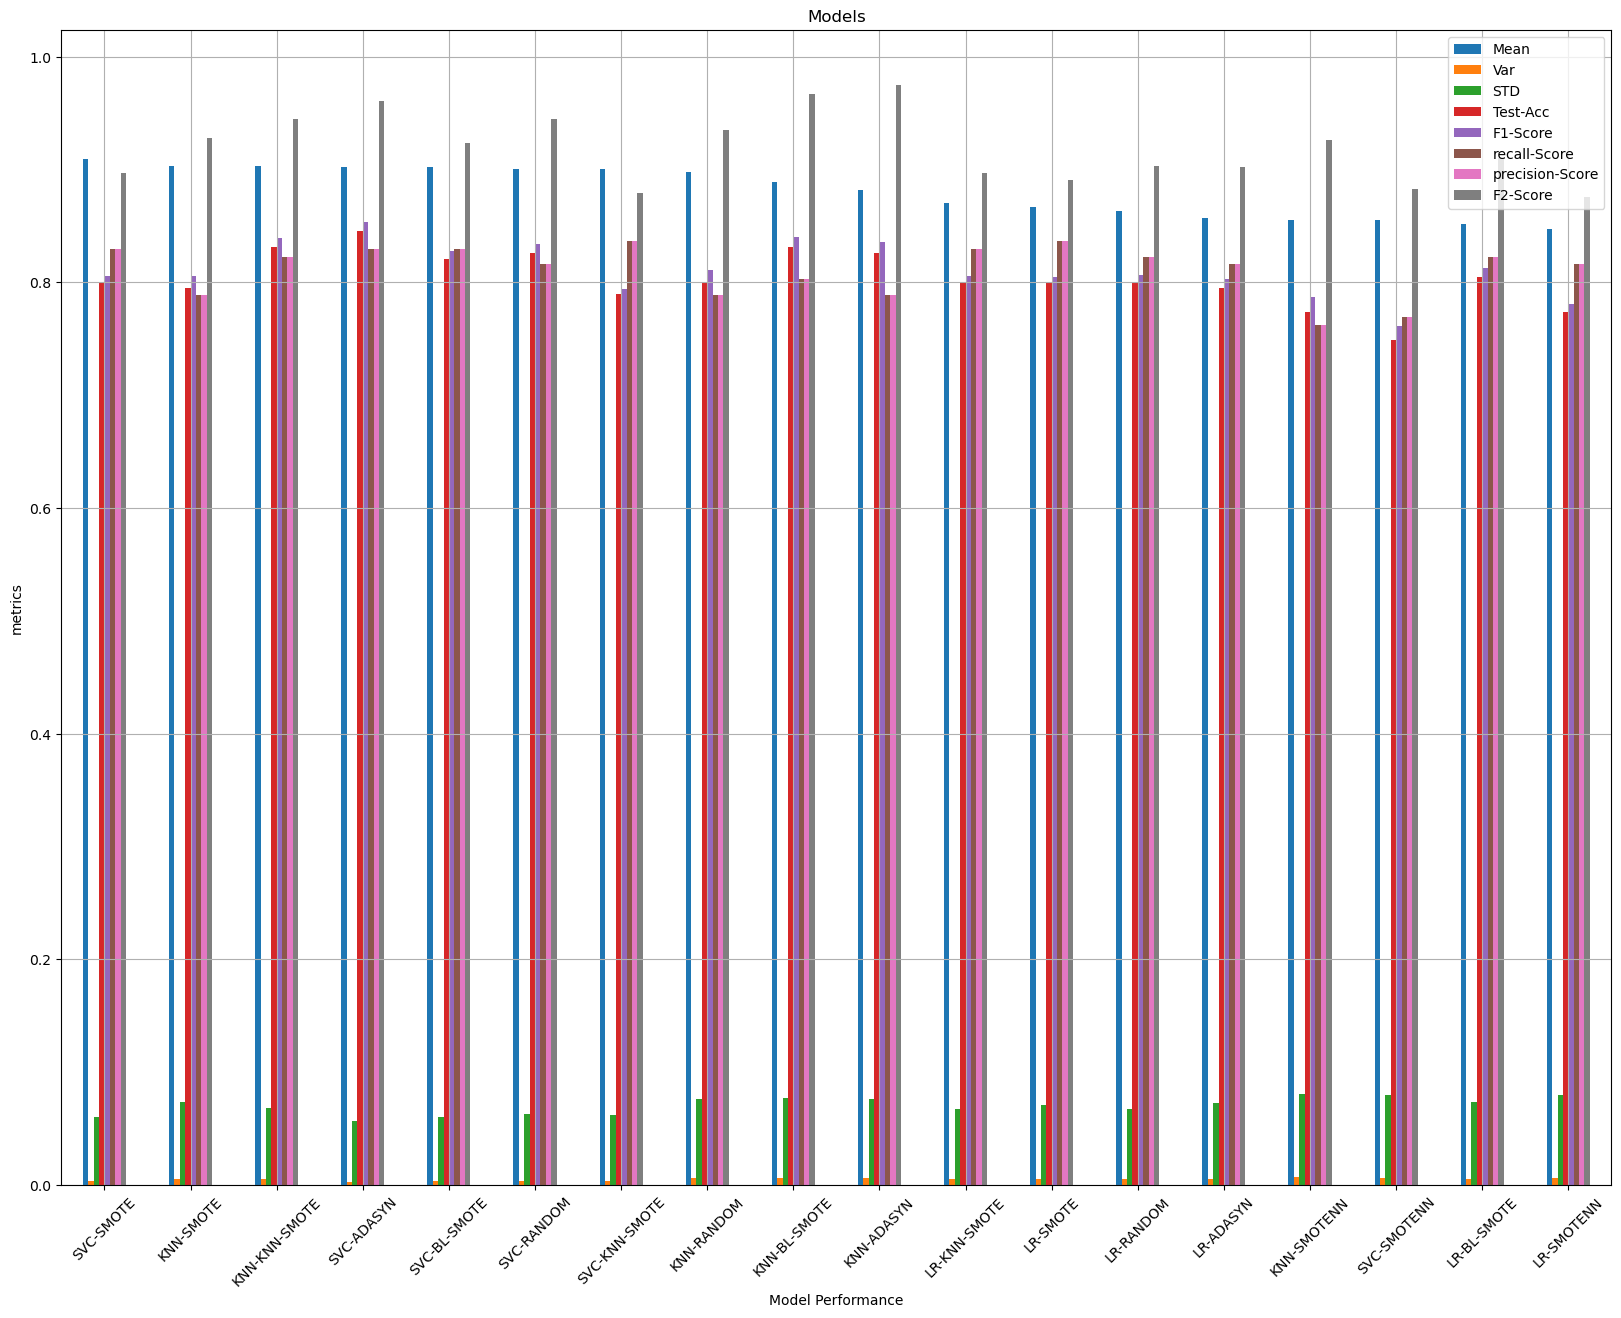

            Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
1       SVC-SMOTE  0.909  0.004  0.060     0.800     0.806         0.830   
2       KNN-SMOTE  0.903  0.005  0.074     0.795     0.806         0.789   
8   KNN-KNN-SMOTE  0.903  0.005  0.068     0.831     0.839         0.823   
13     SVC-ADASYN  0.902  0.003  0.057     0.846     0.854         0.830   
4    SVC-BL-SMOTE  0.902  0.004  0.060     0.821     0.828         0.830   
16     SVC-RANDOM  0.901  0.004  0.063     0.826     0.834         0.816   
7   SVC-KNN-SMOTE  0.901  0.004  0.062     0.790     0.794         0.837   
17     KNN-RANDOM  0.898  0.006  0.076     0.800     0.811         0.789   
5    KNN-BL-SMOTE  0.889  0.006  0.077     0.831     0.840         0.803   
14     KNN-ADASYN  0.882  0.006  0.076     0.826     0.836         0.789   
6    LR-KNN-SMOTE  0.870  0.005  0.067     0.800     0.806         0.830   
0        LR-SMOTE  0.867  0.005  0.071     0.800     0.805         0.837   
15      LR-R

In [73]:
model_names = ["LR", "SVC", "KNN"]
grab_selected_models(model_names)
test_selected_sampling_models(sample_model_names, sample_models, model_names, models, X, y, f2_metric)

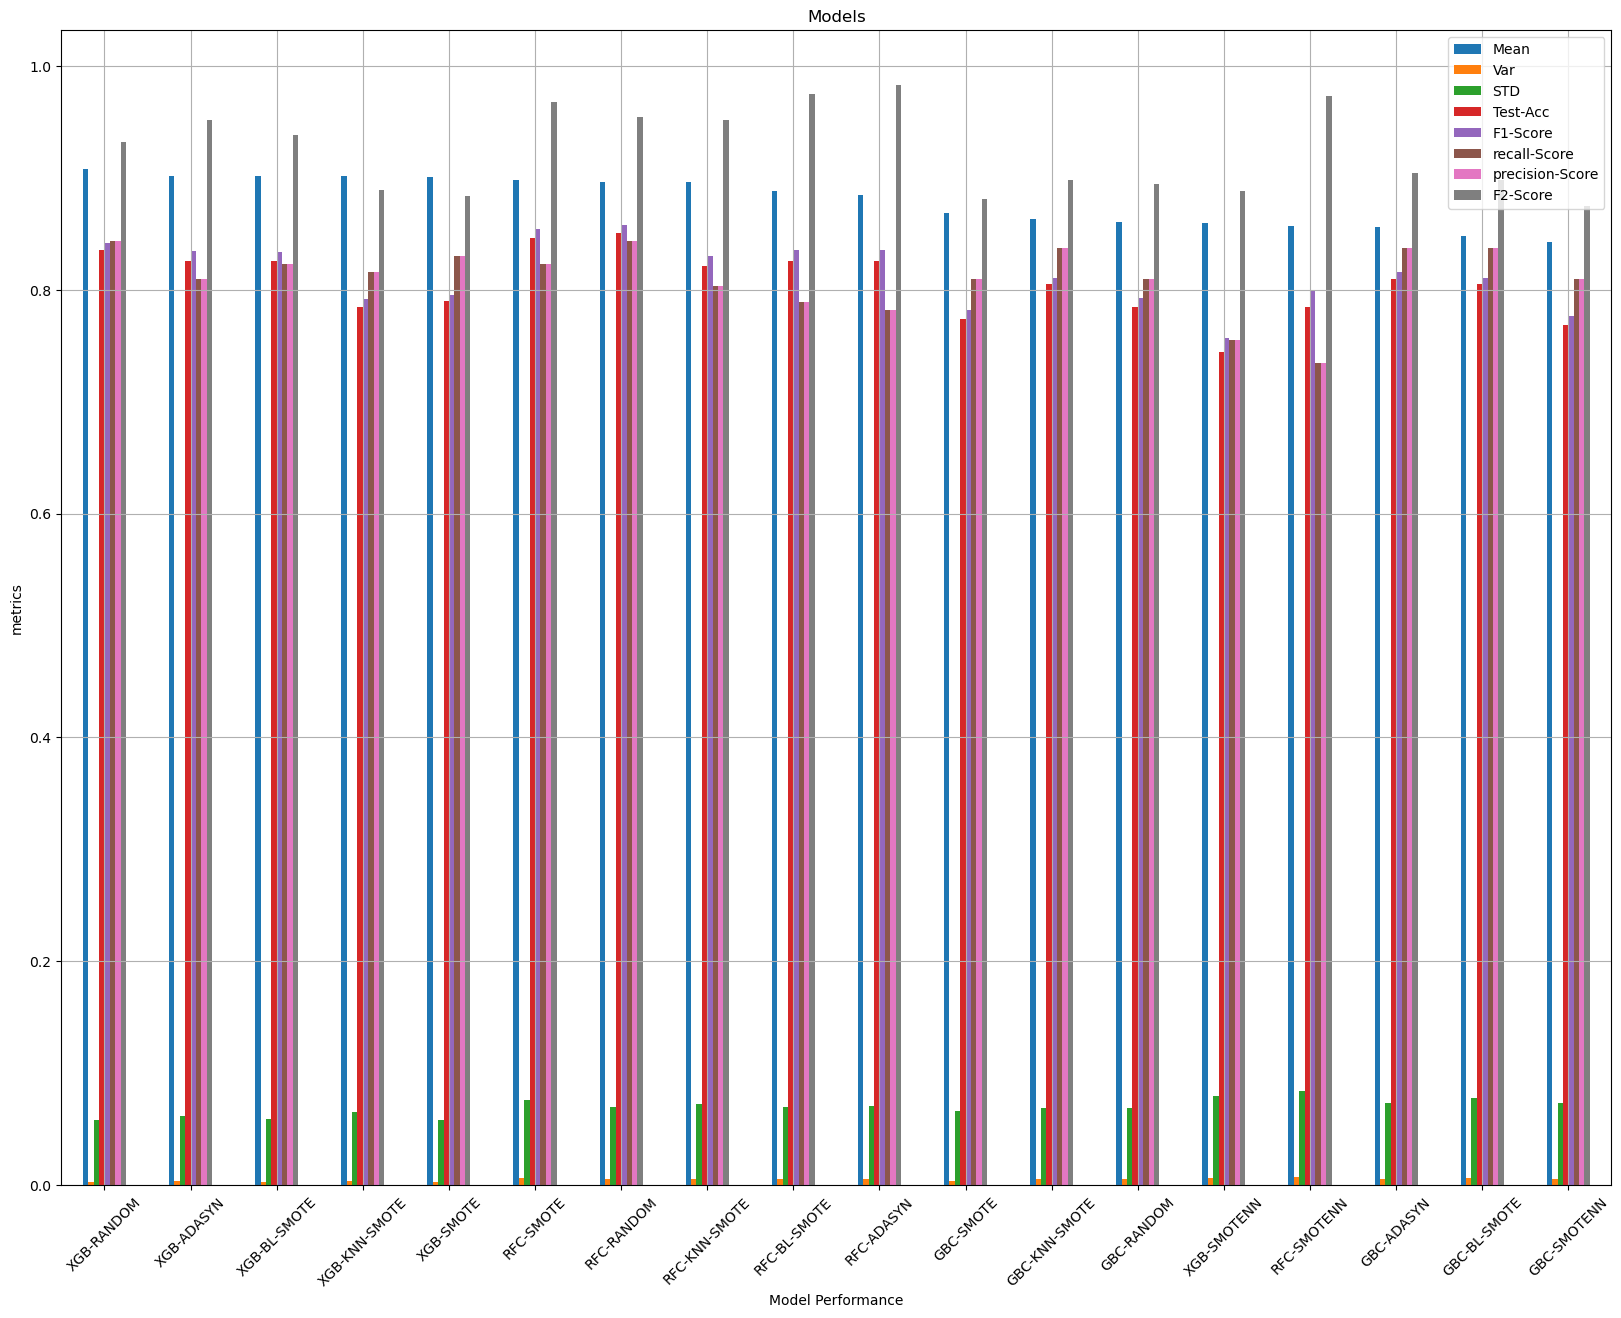

            Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
16     XGB-RANDOM  0.908  0.003  0.058     0.836     0.842         0.844   
13     XGB-ADASYN  0.902  0.004  0.062     0.826     0.835         0.810   
4    XGB-BL-SMOTE  0.902  0.003  0.059     0.826     0.834         0.823   
7   XGB-KNN-SMOTE  0.902  0.004  0.065     0.785     0.792         0.816   
1       XGB-SMOTE  0.901  0.003  0.058     0.790     0.795         0.830   
2       RFC-SMOTE  0.898  0.006  0.076     0.846     0.854         0.823   
17     RFC-RANDOM  0.896  0.005  0.070     0.851     0.858         0.844   
8   RFC-KNN-SMOTE  0.896  0.005  0.072     0.821     0.830         0.803   
5    RFC-BL-SMOTE  0.888  0.005  0.070     0.826     0.836         0.789   
14     RFC-ADASYN  0.885  0.005  0.071     0.826     0.836         0.782   
0       GBC-SMOTE  0.869  0.004  0.066     0.774     0.782         0.810   
6   GBC-KNN-SMOTE  0.863  0.005  0.069     0.805     0.811         0.837   
15     GBC-R

In [74]:
model_names = ["GBC", "XGB", "RFC"]
grab_selected_models(model_names)
test_selected_sampling_models(sample_model_names, sample_models, model_names, models, X, y, f2_metric)